<a href="https://colab.research.google.com/github/Bikash9841/Food-Vision-Mini/blob/main/Food_Vision_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up device-agnostic code

In [2]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get custom data

In [6]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


 # Data Preparation

In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi/train/steak'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Visualize the image

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img
image_path

Random image path: data/pizza_steak_sushi/test/sushi/1383396.jpg
Image class: sushi
Image height: 512
Image width: 384


PosixPath('data/pizza_steak_sushi')

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Perform some transformtion on images

torch.Size([512, 512, 3])
torch.Size([384, 512, 3])
torch.Size([512, 384, 3])


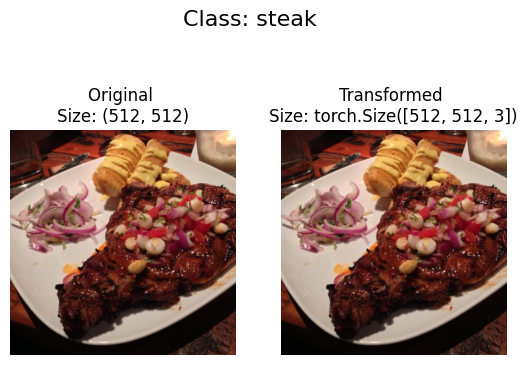

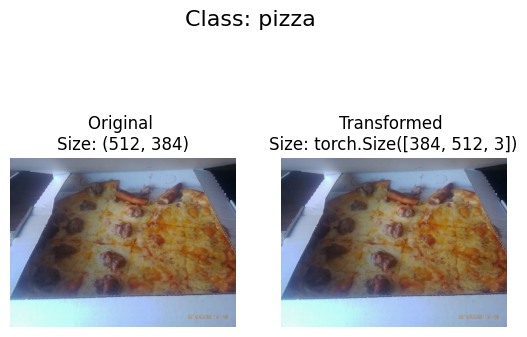

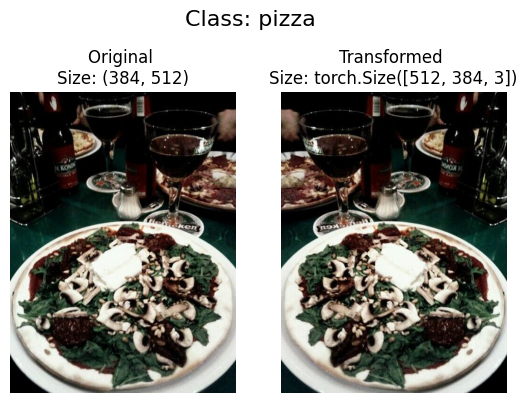

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    # transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            print(transformed_image.shape)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

# Loading Image Data Using ImageFolder

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes

# Can also get class names as a dict
class_dict = train_data.class_to_idx

print(class_names,class_dict)

# Check the lengths
len(train_data), len(test_data)

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}


(450, 150)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.1020, 0.1059, 0.1059,  ..., 0.1137, 0.1098, 0.1098],
         [0.1098, 0.1098, 0.1098,  ..., 0.1098, 0.1137, 0.1176],
         [0.1137, 0.1137, 0.1137,  ..., 0.1098, 0.1176, 0.1216],
         ...,
         [0.1569, 0.1608, 0.1647,  ..., 0.0902, 0.0863, 0.0863],
         [0.1529, 0.1451, 0.1490,  ..., 0.0863, 0.0863, 0.0824],
         [0.1647, 0.1451, 0.1412,  ..., 0.0824, 0.0824, 0.0863]],

        [[0.0471, 0.0510, 0.0510,  ..., 0.0706, 0.0667, 0.0667],
         [0.0549, 0.0549, 0.0549,  ..., 0.0667, 0.0706, 0.0745],
         [0.0588, 0.0588, 0.0588,  ..., 0.0667, 0.0745, 0.0784],
         ...,
         [0.2196, 0.2235, 0.2275,  ..., 0.1059, 0.1020, 0.1020],
         [0.2235, 0.2157, 0.2196,  ..., 0.1020, 0.1020, 0.0980],
         [0.2353, 0.2157, 0.2118,  ..., 0.0980, 0.0980, 0.1020]],

        [[0.0118, 0.0157, 0.0157,  ..., 0.0941, 0.0902, 0.0902],
         [0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0941, 0.0980],
         [0.0235, 0.0235, 0.0235,  ..., 0.09


# Turn loaded images into DataLoader's

In [15]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e54fe986a10>,
 <torch.utils.data.dataloader.DataLoader at 0x7e54f0dc0910>)

In [16]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 512, 512]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Data Augmentation

torch.Size([512, 512, 3])
torch.Size([512, 384, 3])
torch.Size([512, 382, 3])


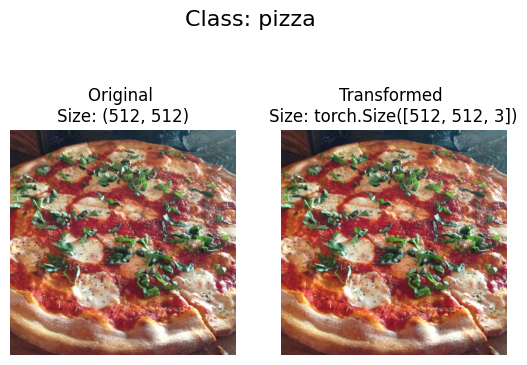

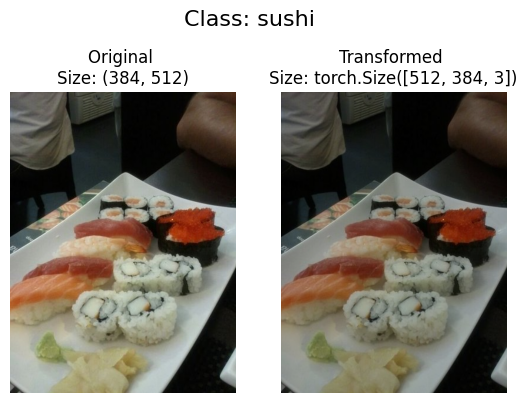

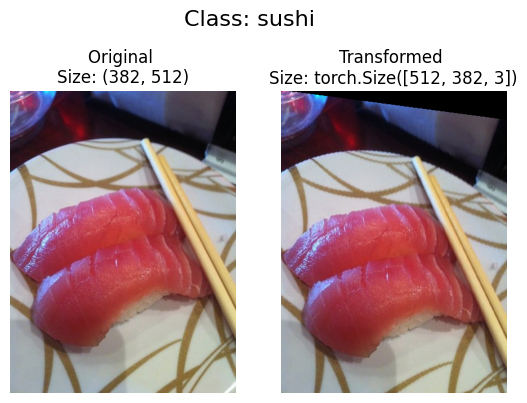

In [17]:
from torchvision import transforms

train_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

# Model 0 : without data augmentation

In [18]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7e54cc43f280>,
 <torch.utils.data.dataloader.DataLoader at 0x7e54f0dc0f40>)

In [43]:
# i wanted to use TinyVGG model from the CNN Explainer website.

class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.

            # look at the output shape from the previous conv block to know about
            # the shape of in_features
            nn.Linear(in_features=hidden_units*53*53,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(f"Ouput Shape after first convolution block: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output Shape after second convolution block: {x.shape}")
        x = self.classifier(x)
        # print(f"Output Shape after classifier layer: {x.shape}")
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=40,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=112360, out_features=3, bias=True)
  )
)

# Try a forward pass on a single image (to test the model)
-- test the input and output shapes of our different layers

In [17]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0161, -0.0045,  0.0288]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3271, 0.3309, 0.3421]], device='cuda:0')

Output prediction label:
tensor([2], device='cuda:0')

Actual label:
2


# Could Use `torchinfo` to know shapes going throug the model

In [18]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 224, 224]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 110, 110]         --
│    └─Conv2d: 2-1                       [1, 20, 222, 222]         560
│    └─ReLU: 2-2                         [1, 20, 222, 222]         --
│    └─Conv2d: 2-3                       [1, 20, 220, 220]         3,620
│    └─ReLU: 2-4                         [1, 20, 220, 220]         --
│    └─MaxPool2d: 2-5                    [1, 20, 110, 110]         --
├─Sequential: 1-2                        [1, 20, 53, 53]           --
│    └─Conv2d: 2-6                       [1, 20, 108, 108]         3,620
│    └─ReLU: 2-7                         [1, 20, 108, 108]         --
│    └─Conv2d: 2-8                       [1, 20, 106, 106]         3,620
│    └─ReLU: 2-9                         [1, 20, 106, 106]         --
│    └─MaxPool2d: 2-10                   [1, 20, 53, 53]           --
├─Seq

# Create train & test loop functions

1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.


In [20]:
from sklearn.metrics import f1_score

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train f1 score
    train_loss, train_f1 = 0, 0

    # Loop through data loader data batches
    # provides 32 image tensor and corresponding label at one go.
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate f1 score across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_f1 += f1_score(y.cpu().numpy(), y_pred_class.cpu().numpy(), average='weighted')

    # Adjust metrics to get average loss and f1 score per batch
    train_loss = train_loss / len(dataloader)
    train_f1 = train_f1 / len(dataloader)
    return train_loss, train_f1

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_f1 = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_f1 += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_f1 = test_f1 / len(dataloader)
    return test_loss, test_f1

In [22]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_f1": [],
        "test_loss": [],
        "test_f1": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_f1 = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_f1 = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_f1: {test_f1:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_f1"].append(test_f1)

    # 6. Return the filled results at the end of the epochs
    return results

# Training `model_0` and evaluation

In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=30,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1088 | train_f1: 0.1929 | test_loss: 1.1418 | test_f1: 0.3286
Epoch: 2 | train_loss: 1.1223 | train_f1: 0.2401 | test_loss: 1.0752 | test_f1: 0.3027
Epoch: 3 | train_loss: 1.0939 | train_f1: 0.2541 | test_loss: 1.0521 | test_f1: 0.4888
Epoch: 4 | train_loss: 1.0259 | train_f1: 0.4193 | test_loss: 0.9852 | test_f1: 0.5866
Epoch: 5 | train_loss: 0.9640 | train_f1: 0.5486 | test_loss: 0.9345 | test_f1: 0.6550
Epoch: 6 | train_loss: 0.8798 | train_f1: 0.5669 | test_loss: 0.8909 | test_f1: 0.6503
Epoch: 7 | train_loss: 0.8438 | train_f1: 0.6363 | test_loss: 0.8869 | test_f1: 0.7063
Epoch: 8 | train_loss: 0.8255 | train_f1: 0.6486 | test_loss: 0.9131 | test_f1: 0.6419
Epoch: 9 | train_loss: 0.8148 | train_f1: 0.6382 | test_loss: 0.8837 | test_f1: 0.6449
Epoch: 10 | train_loss: 0.7974 | train_f1: 0.5656 | test_loss: 0.9471 | test_f1: 0.5641
Epoch: 11 | train_loss: 0.7698 | train_f1: 0.6348 | test_loss: 0.8585 | test_f1: 0.7013
Epoch: 12 | train_loss: 0.7268 | train_f1

In [45]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_f1', 'test_loss', 'test_f1'])

In [23]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_f1": [...],
             "test_loss": [...],
             "test_f1": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    f1Score = results['train_f1']
    test_f1 = results['test_f1']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1Score, label='train_f1')
    plt.plot(epochs, test_f1, label='test_f1')
    plt.title('F1 score')
    plt.xlabel('Epochs')
    plt.legend();

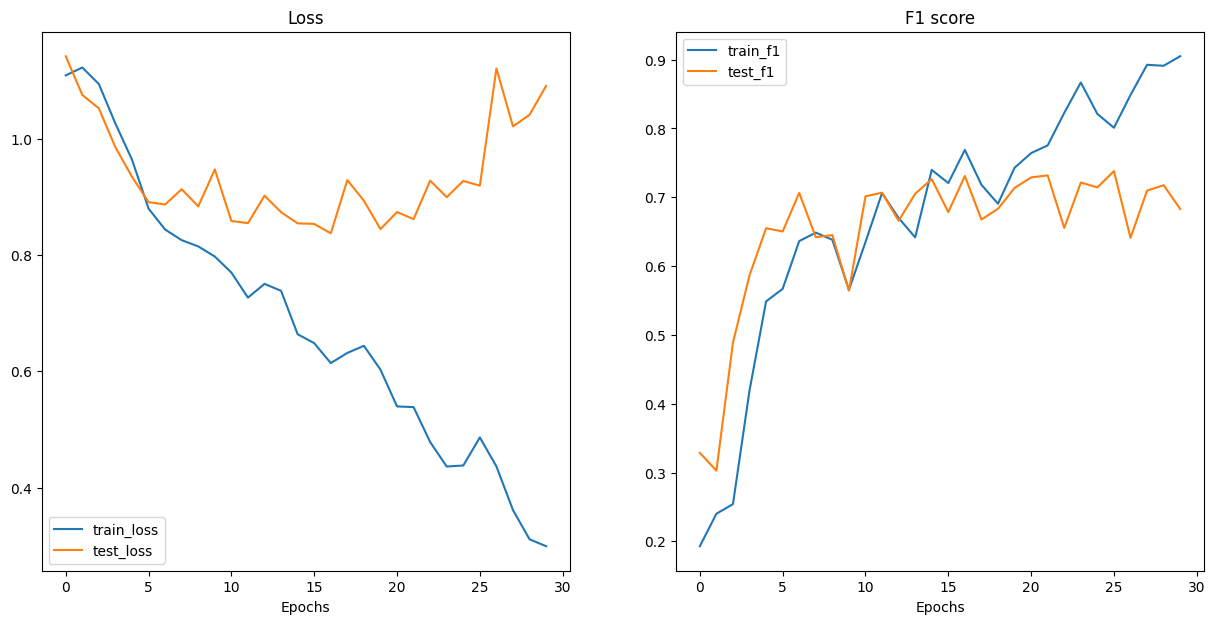

In [52]:
plot_loss_curves(model_0_results)

# Model 1: TinyVGG with Data Augmentation

In [24]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating train and test Datasets and Dataloaders

In [25]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [26]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e54cc43e260>,
 <torch.utils.data.dataloader.DataLoader at 0x7e54f0dc0910>)

In [41]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=40,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=112360, out_features=3, bias=True)
  )
)

# Training `model_1` and Evaluation

In [42]:
# Set random seeds
torch.manual_seed(41)
torch.cuda.manual_seed(41)

# Set number of epochs
NUM_EPOCHS = 40

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} minutes")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1054 | train_f1: 0.1807 | test_loss: 1.0907 | test_f1: 0.4706
Epoch: 2 | train_loss: 1.0891 | train_f1: 0.2804 | test_loss: 1.0558 | test_f1: 0.4950
Epoch: 3 | train_loss: 1.0270 | train_f1: 0.4315 | test_loss: 0.9831 | test_f1: 0.6904
Epoch: 4 | train_loss: 1.0128 | train_f1: 0.4883 | test_loss: 0.9586 | test_f1: 0.5584
Epoch: 5 | train_loss: 1.0176 | train_f1: 0.4260 | test_loss: 0.9355 | test_f1: 0.6030
Epoch: 6 | train_loss: 0.9199 | train_f1: 0.5702 | test_loss: 0.8902 | test_f1: 0.7265
Epoch: 7 | train_loss: 0.9282 | train_f1: 0.5613 | test_loss: 0.8888 | test_f1: 0.6661
Epoch: 8 | train_loss: 0.8665 | train_f1: 0.6299 | test_loss: 0.8525 | test_f1: 0.7688
Epoch: 9 | train_loss: 0.8453 | train_f1: 0.5806 | test_loss: 0.8509 | test_f1: 0.7331
Epoch: 10 | train_loss: 0.9299 | train_f1: 0.5618 | test_loss: 0.8872 | test_f1: 0.6530
Epoch: 11 | train_loss: 0.8854 | train_f1: 0.5600 | test_loss: 0.8629 | test_f1: 0.7128
Epoch: 12 | train_loss: 0.8720 | train_f1

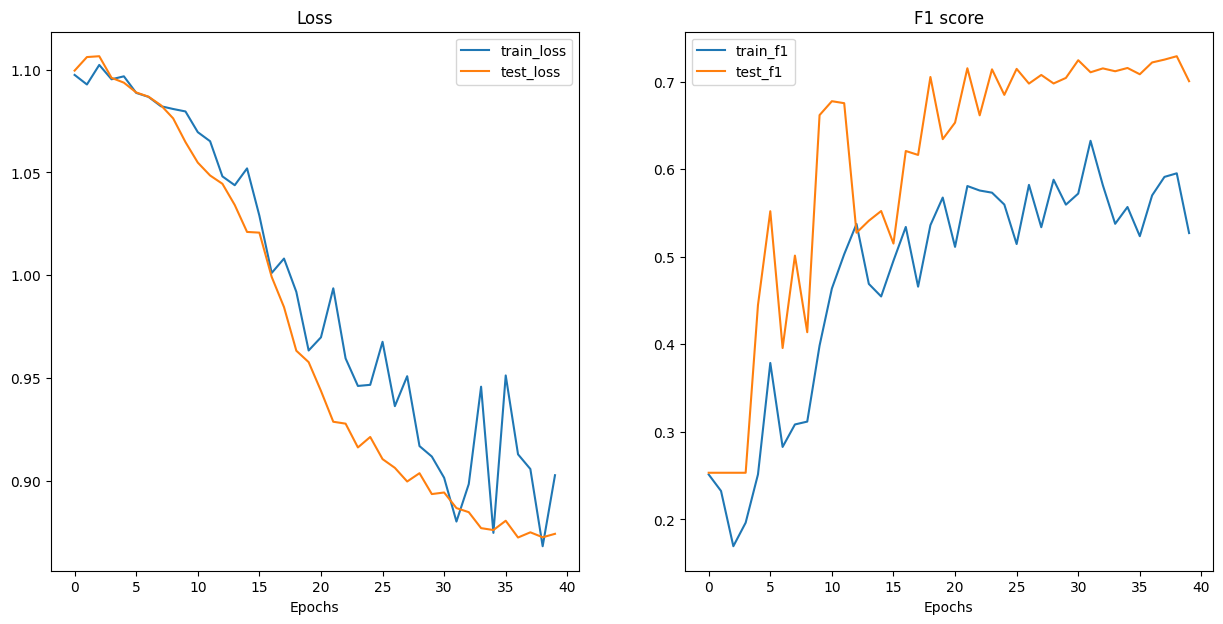

In [39]:
plot_loss_curves(model_1_results)

# Custom image prediction

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

data/04-pizza-dad.jpeg already exists, skipping download.


In [ ]:
import torchvision

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


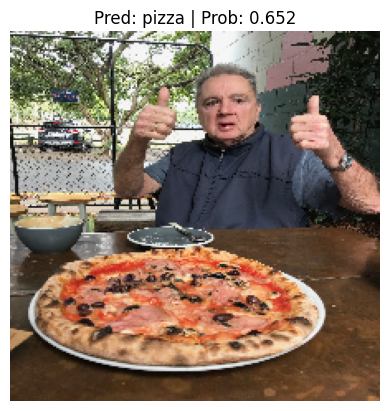

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)